In [145]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.transforms import v2
from PIL import Image
from enum import Enum
import matplotlib.pyplot as plt
import os
import random

In [146]:
class Augmentation(Enum):
    NoAugmentation = 1
    Flip = 2
    Greyscale = 3
    Rotation = 4
    MixUpCutMix = 5

In [147]:
SEED = 0
CINIC_10_FOLDER_PATH = 'CINIC-10'
IMAGE_PATH = f'{CINIC_10_FOLDER_PATH}\\test\\airplane\\cifar10-test-3.png'
NUMBER_OF_CLASSES = 10

# Training process hyperparameters
EPOCHS = 5
LEARNING_RATE = 0.001
BATCH_SIZE = 64

# Regularization hyperparameters
DROPOUT = 0.25
WEIGHT_DECAY = 0 # L1/L2 regularization in Adam optimizer 

# Augmentation
AUGMENTATION = Augmentation.Flip
AUGMENTATION_PREFIX = 'augmentated'
PERCENTAGE_OF_IMAGES_TO_AUGMENT = 50 # for Flip, Greyscale, Rotation
ROTATION_RANGE = [0, 180]

In [148]:
torch.manual_seed(SEED)
print("Is gpu available: " + str(torch.cuda.is_available()))

Is gpu available: True


In [149]:
class SimpleCNN(nn.Module):
    name = "Simple cnn"

    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 16 * 16, 64)
        self.fc2 = nn.Linear(64, NUMBER_OF_CLASSES)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = torch.flatten(x, 1)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [150]:
class AdvancedCNN(nn.Module):
    name = "Advanced cnn"

    def __init__(self):
        super(AdvancedCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, 3, padding=1)
        self.conv2 = nn.Conv2d(64, 128, 3, padding=1)
        self.conv3 = nn.Conv2d(128, 256, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(DROPOUT)
        self.fc1 = nn.Linear(256 * 8 * 8, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, NUMBER_OF_CLASSES)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = self.pool(self.relu(self.conv3(x)))
        x = torch.flatten(x, 1)
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [ ]:
def augment_dataset(dataset, augmentation_transforms, source_path):
    augmented_files = []
    progress_count = 0
    for class_index, class_name in enumerate(dataset.classes):
        class_files = [(dataset.imgs[i][0], label) for i, (_, label) in enumerate(dataset.imgs) if label == class_index]
        
        num_to_augment = int(len(class_files) * (PERCENTAGE_OF_IMAGES_TO_AUGMENT / 100))
        selected_files = random.sample(class_files, num_to_augment)

        for file_path, _ in selected_files:
            img = Image.open(file_path)

            for aug_transform in augmentation_transforms:
                augmented_img = aug_transform(img)
                augmented_filename = f'{AUGMENTATION_PREFIX}_{os.path.basename(file_path)}'
                augmented_filepath = os.path.join(source_path, class_name, augmented_filename)
                augmented_img.save(augmented_filepath)
                augmented_files.append(augmented_filepath)
                progress_count += 1

                if progress_count % 100 == 0:
                    print(f'Progress: {progress_count} images augmented')

augmentation_transforms = {
    Augmentation.NoAugmentation: [],
    Augmentation.Flip: [transforms.RandomHorizontalFlip(1)],
    Augmentation.Greyscale: [transforms.Grayscale(1)],
    Augmentation.Rotation: [transforms.RandomRotation(ROTATION_RANGE)]
}

train_path = f'{CINIC_10_FOLDER_PATH}/train'

if AUGMENTATION != Augmentation.NoAugmentation and AUGMENTATION != Augmentation.MixUpCutMix:
    train_path = f'{CINIC_10_FOLDER_PATH}/train'
    original_dataset = datasets.ImageFolder(train_path)
    augment_dataset(original_dataset, augmentation_transforms[AUGMENTATION], train_path)

In [152]:
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

train_dataset = datasets.ImageFolder(train_path, transform=transform)
test_dataset = datasets.ImageFolder(f'{CINIC_10_FOLDER_PATH}/test', transform=transform)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

model1 = SimpleCNN()
optimizer1 = optim.Adam(model1.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

model2 = AdvancedCNN()
optimizer2 = optim.Adam(model2.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

criterion = nn.CrossEntropyLoss()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Train

In [153]:
def train(model, optimizer):
    model.to(device)

    for epoch in range(EPOCHS):
        model.train()
        images_processed = 0
        for images, labels in train_loader:
            if AUGMENTATION == Augmentation.MixUpCutMix:
                # TODO: investigate this more
                cutmix = v2.CutMix(num_classes=NUMBER_OF_CLASSES)
                mixup = v2.MixUp(num_classes=NUMBER_OF_CLASSES)
                cutmix_or_mixup = v2.RandomChoice([cutmix, mixup])
                images, labels = cutmix_or_mixup(images, labels)
                
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            images_processed += len(images)
            if images_processed % 100 == 0:
                print(f'{model.name} epoch {epoch+1}/{EPOCHS}, Processed {images_processed}/{len(train_dataset)} images')

In [ ]:
train(model1, optimizer1)

In [ ]:
train(model2, optimizer2)

# Test

In [156]:
def test_and_plot(model):
    model.eval()
    class_correct = dict.fromkeys(test_loader.dataset.classes, 0)
    class_total = dict.fromkeys(test_loader.dataset.classes, 0)

    total_batches = len(test_loader)
    processed_batches = 0

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            for label, prediction in zip(labels, predicted):
                if label == prediction:
                    class_correct[test_loader.dataset.classes[label]] += 1
                class_total[test_loader.dataset.classes[label]] += 1

            processed_batches += 1
            print(f"Progress: {processed_batches}/{total_batches} batches processed.")

    overall_correct = sum(class_correct.values())
    overall_total = sum(class_total.values())
    overall_accuracy = 100 * overall_correct / overall_total
    print(f'{model.name} overall accuracy on test set: {overall_accuracy:.2f}%')

    class_accuracies = {classname: 100 * class_correct[classname] / class_total[classname] 
                        for classname in class_correct}

    plt.figure(figsize=(10, 6))
    plt.bar(class_accuracies.keys(), class_accuracies.values(), color='blue')
    plt.xlabel('Class')
    plt.ylabel('Accuracy (%)')
    plt.title(f'{model.name} accuracy per class')
    plt.xticks(rotation=45)
    plt.ylim([0, 100])
    plt.show()

Progress: 1/1407 batches processed.
Progress: 2/1407 batches processed.
Progress: 3/1407 batches processed.
Progress: 4/1407 batches processed.
Progress: 5/1407 batches processed.
Progress: 6/1407 batches processed.
Progress: 7/1407 batches processed.
Progress: 8/1407 batches processed.
Progress: 9/1407 batches processed.
Progress: 10/1407 batches processed.
Progress: 11/1407 batches processed.
Progress: 12/1407 batches processed.
Progress: 13/1407 batches processed.
Progress: 14/1407 batches processed.
Progress: 15/1407 batches processed.
Progress: 16/1407 batches processed.
Progress: 17/1407 batches processed.
Progress: 18/1407 batches processed.
Progress: 19/1407 batches processed.
Progress: 20/1407 batches processed.
Progress: 21/1407 batches processed.
Progress: 22/1407 batches processed.
Progress: 23/1407 batches processed.
Progress: 24/1407 batches processed.
Progress: 25/1407 batches processed.
Progress: 26/1407 batches processed.
Progress: 27/1407 batches processed.
Progress: 

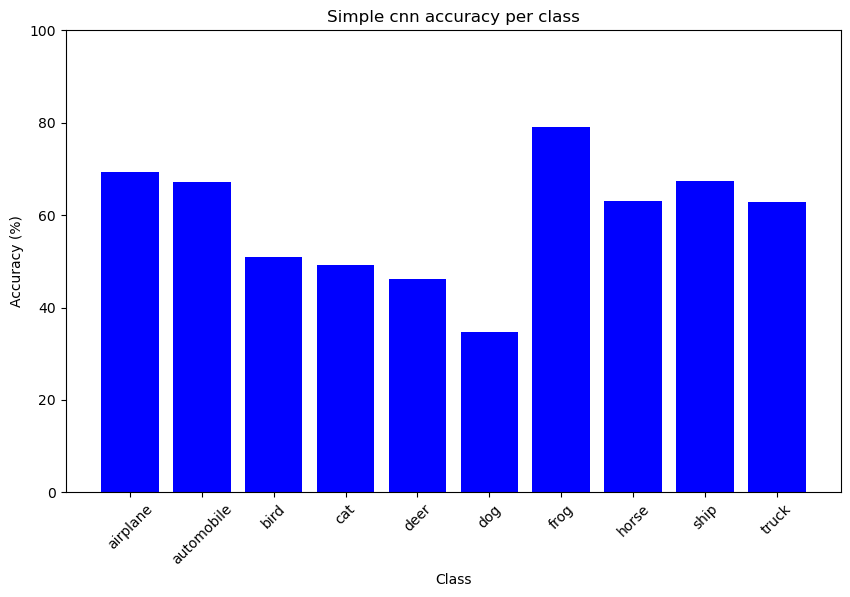

In [157]:
test_and_plot(model1)

Progress: 1/1407 batches processed.
Progress: 2/1407 batches processed.
Progress: 3/1407 batches processed.
Progress: 4/1407 batches processed.
Progress: 5/1407 batches processed.
Progress: 6/1407 batches processed.
Progress: 7/1407 batches processed.
Progress: 8/1407 batches processed.
Progress: 9/1407 batches processed.
Progress: 10/1407 batches processed.
Progress: 11/1407 batches processed.
Progress: 12/1407 batches processed.
Progress: 13/1407 batches processed.
Progress: 14/1407 batches processed.
Progress: 15/1407 batches processed.
Progress: 16/1407 batches processed.
Progress: 17/1407 batches processed.
Progress: 18/1407 batches processed.
Progress: 19/1407 batches processed.
Progress: 20/1407 batches processed.
Progress: 21/1407 batches processed.
Progress: 22/1407 batches processed.
Progress: 23/1407 batches processed.
Progress: 24/1407 batches processed.
Progress: 25/1407 batches processed.
Progress: 26/1407 batches processed.
Progress: 27/1407 batches processed.
Progress: 

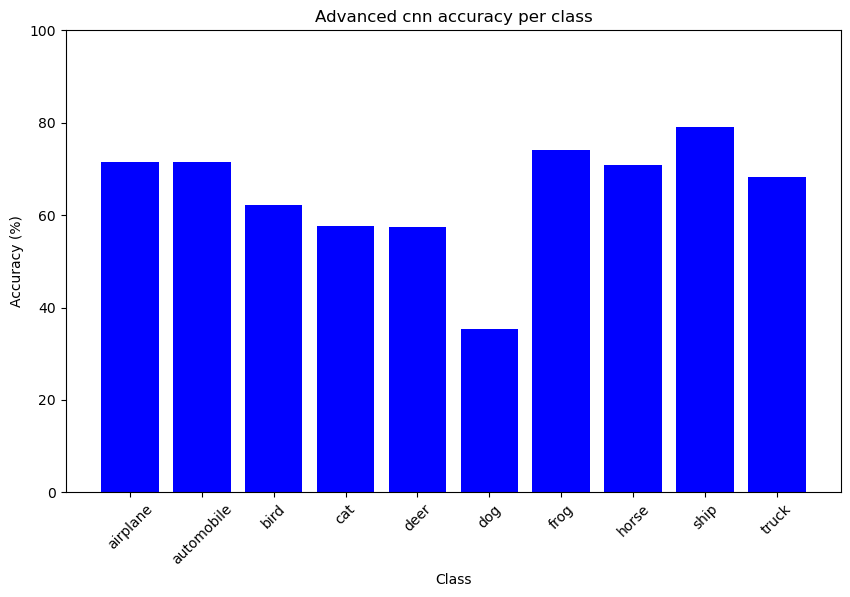

In [158]:
test_and_plot(model2)

# Single image

In [159]:
def predict_single_image(image_path, model):
    image = Image.open(image_path).convert('RGB')

    transform = transforms.Compose([
        transforms.Resize((64, 64)),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

    image = transform(image).unsqueeze(0)
    image = image.to(device)

    model.eval()
    with torch.no_grad():
        output = model(image)
        _, predicted = torch.max(output, 1)

    class_name = test_dataset.classes[predicted.item()]
    print(f'{model.name} cnn predicted class: {class_name}')

In [160]:
predict_single_image(IMAGE_PATH, model1)

Simple cnn cnn predicted class: airplane


In [161]:
predict_single_image(IMAGE_PATH, model2)

Advanced cnn cnn predicted class: airplane


In [ ]:
def cleanup_augmented_files(source_path):
    total_deleted = 0
    for root, _, files in os.walk(source_path):
        for file in files:
            if file.startswith(AUGMENTATION_PREFIX):
                os.remove(os.path.join(root, file))
                total_deleted += 1

                if total_deleted % 100 == 0:
                    print(f"Progress: {total_deleted} augmented files removed.")

    print(f"Cleanup completed: {total_deleted} augmented files removed.")

if AUGMENTATION != Augmentation.NoAugmentation:
    cleanup_augmented_files(train_path)